In [1]:
import pandas as pd
import numpy as np

from model_explorer.result_handling.collect_results import collect_results

In [2]:
results_005 = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/deeplab_fog_0.005.pkl')
results_01 = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/deeplab_fog_0.01.pkl')
results_015 = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/deeplab_fog_0.015.pkl')
results_no = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/deeplab_nocondition.pkl')

def convert(df):
    df[['acc_pixel']] = pd.DataFrame(df.accuracies.tolist(), index=df.index)
    df = df[df['acc_pixel'] > results_005.accuracy_limit]
    return df

df_005 = convert(results_005.to_dataframe())
df_01 = convert(results_01.to_dataframe())
df_015 = convert(results_015.to_dataframe())
df_no = convert(results_no.to_dataframe())

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [3]:
df_005.count()

generation         180
individual         180
accuracies         180
mutation_eta       180
mutation_prob      180
crossover_eta      180
crossover_prob     180
selection_press    180
F_0                180
parameters         180
acc_pixel          180
dtype: int64

<AxesSubplot: xlabel='acc_pixel', ylabel='F_0'>

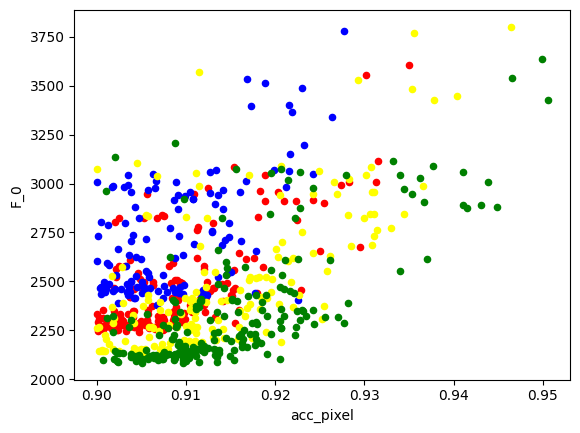

In [9]:
ax = df_005.plot(kind='scatter', x='acc_pixel', y='F_0', c='red')
df_01.plot(ax=ax, kind='scatter', x='acc_pixel', y='F_0', c='blue')
df_015.plot(ax=ax, kind='scatter', x='acc_pixel', y='F_0', c='yellow')
df_no.plot(ax=ax, kind='scatter', x='acc_pixel', y='F_0', c='green')